In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas_profiling

In [3]:
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [4]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc, rcParams

def set_korea_font():
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
    rcParams.update({'font.size': 11})
    rcParams['axes.unicode_minus'] = False  
set_korea_font()

## < Clustering할 최종 USER data >
- 5094명의 data

> NUMERIC
- 1) 누적 주문 건수
- 2) 총 사용 적립금
- 3) 총 실주문 건수
- 4) 총 구매금액
- 5) 주문 경로 ( = PC/모바일 주문 비율 ( PC 비율로 표기 ) )
- 6) 쿠폰 할인금액
- 7) 이용기간 ( 회원가입일~최종접속일 )
- 8) 최근 접속까지의 일 수 ( 2019.10.10 - 최근접속 )

> BOOLEAN
- 9) 추천인 아이디 유무 (0,1)
- 10) 평생회원 여부 (0,1)

> CATEGORICAL -> ONE HOT ENCODING하기
- 11) 회원 구분 ( 개인 / 사업자 ) 
- 12) 회원 등급 ( 일반 / 전화주문 / 사업자 / 기타 )
- 13) 회원 가입 경로 ( 인쇄물 / 인터넷 / 기타 / 없음 )

# FOUR DATA

### 1) user : dummy화 X, scaling X
### 2) user_dm : dummy화 O , scaling X
### 3) user_dmsc : dummy화 O, scaling O
### 4) pcadf : pc 8개로 차원축소한 data

In [5]:
user = pd.read_csv('usersummary.csv')

In [6]:
user = user.set_index('아이디')

In [30]:
user.head()

,누적주문건수,총 사용 적립금,총구매금액,추천인아이디,평생회원,회원구분_x,회원등급,회원추가항목_가입경로,PC_,주문서 쿠폰 할인금액,이용기간,최근접속
아이디,,,,,,,,,,,,
cgh1385,1.0,0.0,70500.0,0,0.0,개인,일반,없음,0.666667,0.0,1,1032
pjkl77,3.0,0.0,63000.0,0,0.0,사업자,사업자,없음,0.555556,8000.0,43,977
bear011,37.0,31900.0,2870970.0,0,0.0,사업자,사업자,없음,0.867925,0.0,701,316
kim0750,1.0,0.0,77700.0,0,0.0,사업자,사업자,없음,1.000000,5000.0,0,1016
nonane9979,3.0,0.0,238900.0,0,0.0,사업자,사업자,없음,0.875000,0.0,26,990


In [31]:
user.shape

(5094, 12)

pandas_profiling.ProfileReport(user)

### One-hot Encoding

In [8]:
# 5094명 중, 특별회원/딜러/관리자는 각각 12, 2, 2명밖에 없음 -> "기타"로 처리
user['회원등급'][(user['회원등급']=='특별회원')|(user['회원등급']=='딜러')|(user['회원등급']=='관리자')] = '기타'

In [9]:
a1= pd.get_dummies(user.iloc[:,5],prefix='회원 구분')
a2 = pd.get_dummies(user.iloc[:,6],prefix='회원 등급')
a3 = pd.get_dummies(user.iloc[:,7],prefix='가입 경로')

In [10]:
user_dm = pd.concat([user,a1,a2,a3],axis=1)

In [11]:
user_dm = user_dm.drop(['회원구분_x','회원등급','회원추가항목_가입경로'],axis=1)

In [12]:
user_dm.shape

(5094, 22)

In [32]:
user_dm.columns

Index(['누적주문건수', '총 사용 적립금', '총구매금액', '추천인아이디', '평생회원', 'PC_', '주문서 쿠폰 할인금액',
       '이용기간', '최근접속', '회원 구분_개인', '회원 구분_사업자', '회원 등급_기타', '회원 등급_딜러 유치 회원',
       '회원 등급_사업자', '회원 등급_일반', '회원 등급_전화주문 고객', '가입 경로_기타', '가입 경로_없음',
       '가입 경로_인터넷 검색', '가입 경로_잡지를 통해', '가입 경로_전단지 인쇄물을 통해', '가입 경로_지인 추천을 통해'],
      dtype='object')

In [13]:
user_dm.describe()

,누적주문건수,총 사용 적립금,총구매금액,추천인아이디,평생회원,PC_,주문서 쿠폰 할인금액,이용기간,최근접속,회원 구분_개인,...,회원 등급_딜러 유치 회원,회원 등급_사업자,회원 등급_일반,회원 등급_전화주문 고객,가입 경로_기타,가입 경로_없음,가입 경로_인터넷 검색,가입 경로_잡지를 통해,가입 경로_전단지 인쇄물을 통해,가입 경로_지인 추천을 통해
count,5094.00000,5094.000000,5.094000e+03,5094.000000,5094.000000,5094.000000,5.094000e+03,5094.000000,5094.000000,5094.000000,...,5094.000000,5094.00000,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000
mean,8.54947,3485.254024,6.258606e+05,0.030624,0.488810,0.583091,1.944321e+03,102.453867,313.302905,0.637417,...,0.018453,0.31115,0.341775,0.325481,0.035925,0.663918,0.069690,0.064389,0.110718,0.055359
std,16.78540,18544.824818,1.400586e+06,0.172314,0.499924,0.320531,3.458667e+04,140.001258,172.656431,0.480793,...,0.134596,0.46301,0.474351,0.468600,0.186120,0.472414,0.254649,0.245470,0.313814,0.228703
min,1.00000,0.000000,1.320000e+03,0.000000,0.000000,0.000000,0.000000e+00,0.000000,93.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.00000,0.000000,9.766750e+04,0.000000,0.000000,0.333333,0.000000e+00,0.000000,177.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.00000,0.000000,2.096750e+05,0.000000,0.000000,0.547727,0.000000e+00,27.000000,247.000000,1.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,8.00000,0.000000,5.551250e+05,0.000000,1.000000,0.857143,0.000000e+00,170.000000,399.000000,1.000000,...,0.000000,1.00000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,295.00000,537270.000000,2.848858e+07,1.000000,1.000000,1.000000,2.279240e+06,819.000000,1032.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
user_dm.to_csv('user_dummyO_scalingX.csv')

### Scaling

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
sc = StandardScaler()
sc.fit(user_dm[['누적주문건수','총 사용 적립금','총구매금액','주문서 쿠폰 할인금액','이용기간','최근접속']])
user_scaled = sc.fit_transform(user_dm[['누적주문건수','총 사용 적립금','총구매금액','주문서 쿠폰 할인금액','이용기간','최근접속']])

In [17]:
user_dmsc = user_dm.copy()
user_dmsc[['누적주문건수','총 사용 적립금','총구매금액','주문서 쿠폰 할인금액','이용기간','최근접속']] = user_scaled

In [18]:
user_dmsc.head()

,누적주문건수,총 사용 적립금,총구매금액,추천인아이디,평생회원,PC_,주문서 쿠폰 할인금액,이용기간,최근접속,회원 구분_개인,...,회원 등급_딜러 유치 회원,회원 등급_사업자,회원 등급_일반,회원 등급_전화주문 고객,가입 경로_기타,가입 경로_없음,가입 경로_인터넷 검색,가입 경로_잡지를 통해,가입 경로_전단지 인쇄물을 통해,가입 경로_지인 추천을 통해
아이디,,,,,,,,,,,,,,,,,,,,,
cgh1385,-0.449808,-0.187955,-0.396559,0,0.0,0.666667,-0.056221,-0.724735,4.162994,1,...,0,0,1,0,0,1,0,0,0,0
pjkl77,-0.330645,-0.187955,-0.401915,0,0.0,0.555556,0.175104,-0.424708,3.844411,0,...,0,1,0,0,0,1,0,0,0,0
bear011,1.695123,1.532370,1.603136,0,0.0,0.867925,-0.056221,4.275711,0.015623,0,...,0,1,0,0,0,1,0,0,0,0
kim0750,-0.449808,-0.187955,-0.391418,0,0.0,1.000000,0.088357,-0.731879,4.070315,0,...,0,1,0,0,0,1,0,0,0,0
nonane9979,-0.330645,-0.187955,-0.276312,0,0.0,0.875000,-0.056221,-0.546148,3.919712,0,...,0,1,0,0,0,1,0,0,0,0


### outlier 제거 ( Z값 +3,-3 바깥 )

In [19]:
from scipy import stats

for i in ['누적주문건수','총 사용 적립금','총구매금액','주문서 쿠폰 할인금액','이용기간','최근접속']:
    user_dmsc = user_dmsc[np.abs(user_dmsc[i]-user_dmsc[i].mean()) <= (3*user_dmsc[i].std())]

In [20]:
user_dmsc.to_csv('user_dummyO_scalingO.csv')

In [21]:
user_dmsc.shape

(4583, 22)

# MODELING
- k-means ( simple )
- hierarchical ( cluster간의 대분류/중분류/소분류 가능 )
- SOM ( new data따라 계속 update 가능하므로 )

In [22]:
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from som import SOM

In [23]:
#from sklearn.metrics import silhouette_score

## < PCA >

### 8개로 92%설명!

In [24]:
pca = PCA(n_components=8)
pca.fit(user_dmsc)
pca_values = pca.transform(user_dmsc)

In [25]:
sum(pca.explained_variance_ratio_).round(2)

0.9

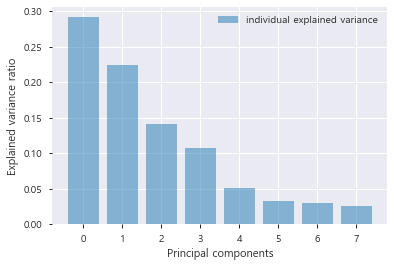

In [26]:
plt.figure(figsize=(6, 4))
plt.bar(range(8),pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

In [27]:
pcadf = pd.DataFrame(pca_values, columns = ['pc'+str(i) for i in range(1,9)])
pcadf.head(5)
pcadf.index = user_dmsc.index
pcadf.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8
아이디,,,,,,,,
91559380,0.359893,-0.733428,2.474140,1.423490,-0.700689,-0.488936,-0.797622,0.034800
danbi531,-1.431374,-0.144208,2.212528,1.117344,-0.552615,-0.132613,-0.687181,0.071707
scsodamae,-0.783358,1.390950,2.603797,0.260452,-0.460697,0.464107,0.615058,-0.225362
ehfdl1108,-0.981171,1.298937,2.386230,0.006509,-0.530484,-0.543432,-0.107830,0.013430
wanya,-1.928318,0.072628,1.954450,1.096761,-0.551976,0.148392,-0.409228,-0.031211


In [29]:
pcadf.to_csv('pcadf.csv')

# CLUSTERING

In [28]:
import collections

## 1) K-means

In [ ]:
sse = [] # sum of squares error

for i in range(3,12) :
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(pcadf)
    sse.append(kmeans.inertia_)

#### 그래프만 봐서는 몇개가 최적인지 알기 어렵다.
- k=4,5,6 정도로 다 해봐서 insight 발견할 수 있는 k로 설정하기!

In [ ]:
plt.plot(range(3,12),sse)

In [ ]:
k5 = KMeans(n_clusters=5)
k5.fit(pcadf)

In [ ]:
collections.Counter(k5.labels_)

In [ ]:
pcadf_kmeans = pcadf.copy()
pcadf_kmeans['cluster'] = k5.labels_

In [ ]:
pcadf_kmeans['cluster'].value_counts()

In [ ]:
plt.figure(figsize=(15,15))
sns.scatterplot(x="pc1", y="pc2", hue="cluster",palette="Set2",data=pcadf_kmeans)

In [ ]:
#ltns['cluster'] = pd.Series(kproto.labels_, index=ltns.index)

## Hierarchical Clustering

In [ ]:
h20 =AgglomerativeClustering(n_clusters=20)
h20.fit(pcadf)

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
mergings = linkage(pcadf,method='complete')

## 3. SOM

### 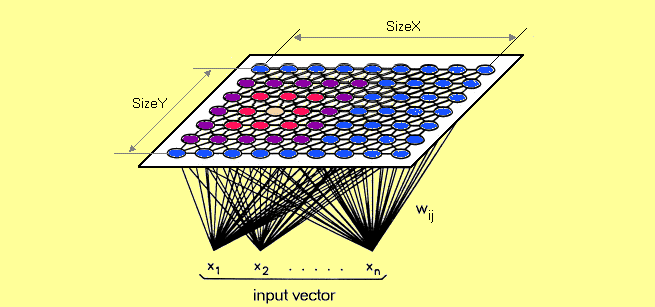

https://machinelearningnepal.com/2018/01/17/online-som/ 

In [ ]:
#from online_som import SOM
from online_som import SOM

In [ ]:
def predict3x3(df):
    bmu, bmu_idx = agri_som.find_bmu(df.values)
    df['bmu'] = bmu
    df['bmu_idx'] = bmu_idx
    return df

In [ ]:
def predict2x2(df):
    bmu, bmu_idx = agri_som2.find_bmu(df.values)
    df['bmu'] = bmu
    df['bmu_idx'] = bmu_idx
    return df

### 3x3

In [ ]:
agri_som = SOM(3,3,8)
agri_som.train(pcadf.values,
          num_epochs=200,
          init_learning_rate=0.01
          )

### 2x2

In [ ]:
agri_som2 = SOM(2,2,8)
agri_som2.train(pcadf.values,
          num_epochs=200,
          init_learning_rate=0.01
          )

### 3x3

In [ ]:
clustered_df = pcadf.apply(predict3x3, axis=1)
clustered_df['bmu_idx'] = clustered_df['bmu_idx'].astype('str')

In [ ]:
clustered_df['bmu_idx'].value_counts()

In [ ]:
user_SOM = user[user.index.isin(user_dmsc.index)]
user_SOM['cluster'] = pd.Series(clustered_df['bmu_idx'])

In [ ]:
clustered_df.to_csv('3x3_pca.csv')

In [ ]:
user_SOM.to_csv('3x3_user.csv')

### 2x2

In [ ]:
clustered_df2 = pcadf.apply(predict2x2, axis=1)
clustered_df2['bmu_idx'] = clustered_df2['bmu_idx'].astype('str')

In [ ]:
user_SOM2 = user[user.index.isin(user_dmsc.index)]
user_SOM2['cluster'] = pd.Series(clustered_df2['bmu_idx'])

In [ ]:
clustered_df2.to_csv('2x2_pca.csv')

In [ ]:
user_SOM2.to_csv('2x2_user.csv')

## Visualization 3x3

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="pc1", y="pc2", hue="bmu_idx",data=clustered_df)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(clustered_df[clustered_df['bmu_idx']=='[0 0]']['pc1'],
           clustered_df[clustered_df['bmu_idx']=='[0 0]']['pc2'],
           clustered_df[clustered_df['bmu_idx']=='[0 0]']['pc3'], c='#42d4f4', marker='o')
ax.scatter(clustered_df[clustered_df['bmu_idx']=='[0 1]']['pc1'],
           clustered_df[clustered_df['bmu_idx']=='[0 1]']['pc2'],
           clustered_df[clustered_df['bmu_idx']=='[0 1]']['pc3'], c='#e6194B', marker='o')
ax.scatter(clustered_df[clustered_df['bmu_idx']=='[0 2]']['pc1'],
           clustered_df[clustered_df['bmu_idx']=='[0 2]']['pc2'],
           clustered_df[clustered_df['bmu_idx']=='[0 2]']['pc3'], c='#f58231', marker='o')
ax.scatter(clustered_df[clustered_df['bmu_idx']=='[1 0]']['pc1'],
           clustered_df[clustered_df['bmu_idx']=='[1 0]']['pc2'],
           clustered_df[clustered_df['bmu_idx']=='[1 0]']['pc3'], c='#3cb44b', marker='o')
ax.scatter(clustered_df[clustered_df['bmu_idx']=='[1 1]']['pc1'],
           clustered_df[clustered_df['bmu_idx']=='[1 1]']['pc2'],
           clustered_df[clustered_df['bmu_idx']=='[1 1]']['pc3'], c='#4363d8', marker='o')
ax.scatter(clustered_df[clustered_df['bmu_idx']=='[1 2]']['pc1'],
           clustered_df[clustered_df['bmu_idx']=='[1 2]']['pc2'],
           clustered_df[clustered_df['bmu_idx']=='[1 2]']['pc3'], c='#911eb4', marker='o')
ax.scatter(clustered_df[clustered_df['bmu_idx']=='[2 0]']['pc1'],
           clustered_df[clustered_df['bmu_idx']=='[2 0]']['pc2'],
           clustered_df[clustered_df['bmu_idx']=='[2 0]']['pc3'], c='#f032e6', marker='o')
ax.scatter(clustered_df[clustered_df['bmu_idx']=='[2 1]']['pc1'],
           clustered_df[clustered_df['bmu_idx']=='[2 1]']['pc2'],
           clustered_df[clustered_df['bmu_idx']=='[2 1]']['pc3'], c='#469990', marker='o')
ax.scatter(clustered_df[clustered_df['bmu_idx']=='[2 2]']['pc1'],
           clustered_df[clustered_df['bmu_idx']=='[2 2]']['pc2'],
           clustered_df[clustered_df['bmu_idx']=='[2 2]']['pc3'], c='#000000', marker='o')
    

ax.set_xlabel('PC1')
ax.set_xlim(-2,2)
ax.set_ylabel('PC2')
ax.set_ylim(-1,2)
ax.set_zlabel('PC3')
ax.set_zlim(-2,2)

plt.show()

## Visualization 2x2

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="pc1", y="pc2", hue="bmu_idx",data=clustered_df2)

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(clustered_df2[clustered_df2['bmu_idx']=='[0 0]']['pc1'],
           clustered_df2[clustered_df2['bmu_idx']=='[0 0]']['pc2'],
           clustered_df2[clustered_df2['bmu_idx']=='[0 0]']['pc3'], c='#42d4f4', marker='o',label='[0 0]')
ax.scatter(clustered_df2[clustered_df2['bmu_idx']=='[0 1]']['pc1'],
           clustered_df2[clustered_df2['bmu_idx']=='[0 1]']['pc2'],
           clustered_df2[clustered_df2['bmu_idx']=='[0 1]']['pc3'], c='#e6194B', marker='o',label='[0 1]')
ax.scatter(clustered_df2[clustered_df2['bmu_idx']=='[1 0]']['pc1'],
           clustered_df2[clustered_df2['bmu_idx']=='[1 0]']['pc2'],
           clustered_df2[clustered_df2['bmu_idx']=='[1 0]']['pc3'], c='#f58231', marker='o',label='[1 0]')
ax.scatter(clustered_df2[clustered_df2['bmu_idx']=='[1 1]']['pc1'],
           clustered_df2[clustered_df2['bmu_idx']=='[1 1]']['pc2'],
           clustered_df2[clustered_df2['bmu_idx']=='[1 1]']['pc3'], c='#3cb44b', marker='o',label='[1 1]')

ax.set_xlabel('PC1')
ax.set_xlim(-2,2)
ax.set_ylabel('PC2')
ax.set_ylim(-1,2)
ax.set_zlabel('PC3')
ax.set_zlim(-2,2)
plt.legend(prop={'size': 16})
plt.show()

## pair plot

In [ ]:
sns.pairplot(data=clustered_df[['pc1','pc2','pc3','bmu_idx']],  hue='bmu_idx', size=10)

In [ ]:
sns.pairplot(data=clustered_df2[['pc1','pc2','pc3','bmu_idx']],  hue='bmu_idx', size=10)